# Examples from manuscript

Code to run the examples reported in https://arxiv.org/abs/2009.01077

In [1]:
import sys
sys.path.append('../../reval_clustering/')

from reval.best_nclust_cv import FindBestClustCV
from reval.internal_baselines import select_best, evaluate_best
from reval.visualization import plot_metrics
from reval.utils import kuhn_munkres_algorithm, compute_metrics
from reval.param_selection import ParamSelection, SCParamSelection
from datasets.manuscript_builddatasets import build_ucidatasets

from sklearn.datasets import make_blobs, load_digits
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.metrics import zero_one_loss, adjusted_mutual_info_score, silhouette_score, davies_bouldin_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
import hdbscan
from umap import UMAP
import numpy as np

import pandas as pd
import pickle as pkl
import logging
import matplotlib.pyplot as plt

# Modify this variable for parallelization
N_JOBS=7

Three example functions that can also be run from shell (see manuscript_examples.py file). 

> Example 1: blobs dataset;

> Example 2: real-world dataset MNIST;

> Example 3: best clussifier-clustering combinations for 18 datasets from UCI Machine Learning Repository.

## Example 1: blobs dataset

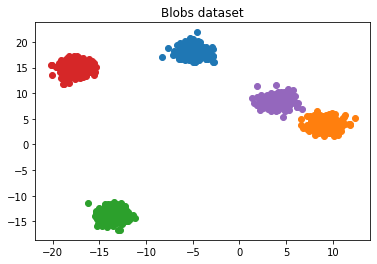

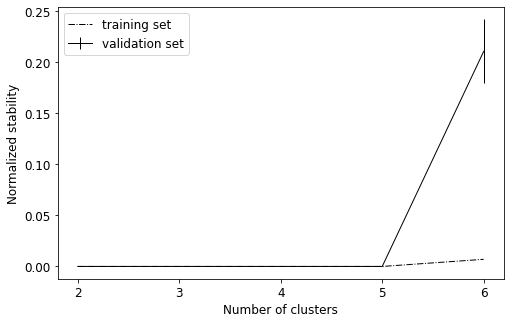

18:40:58, INFO Validation stability: (0.0, (0.0, 0.0))
18:40:58, INFO Best number of clusters: 5
18:40:58, INFO AMI (true labels vs predicted labels) for test set = 1.0
18:40:58, INFO 


18:40:58, INFO Metrics from true label comparisons on test set:
18:40:58, INFO MCC, 1.0
18:40:58, INFO F1, 1.0
18:40:58, INFO 


18:40:58, INFO Silhouette score based selection
18:40:59, INFO Best number of clusters (and scores) for tr/ts independent runs: 5(0.829986284785402)/5(0.8318685705425193)
18:40:59, INFO Test set evaluation 0.8318685705425193
18:40:59, INFO AMI (true labels vs clustering labels) training = 1.0
18:40:59, INFO AMI (true labels vs clustering labels) test = 1.0
18:40:59, INFO 


18:40:59, INFO Davies-Bouldin score based selection
18:40:59, INFO Best number of clusters (and scores) for tr/ts independent runs: 4(0.2318870517666557)/5(0.23332007909711142)
18:40:59, INFO Test set evaluation 0.238345242770787
18:40:59, INFO AMI (true labels vs clustering labels) training = 0.9051891235

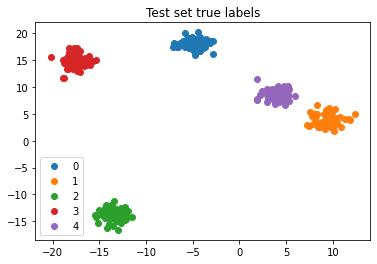

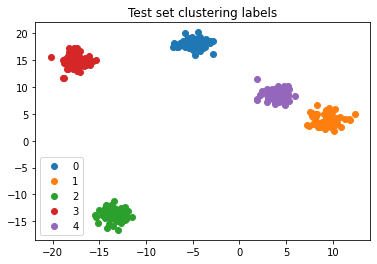

In [49]:
# EXAMPLE 1: Isotropic Gaussian blobs
# Generate dataset
data = make_blobs(1000, 2, centers=5, 
                  center_box=(-20, 20),
                  random_state=42)

# Visualize dataset
plt.figure(figsize=(6, 4))
for i in range(5):
    plt.scatter(data[0][data[1]==i][:, 0],
                data[0][data[1]==i][:, 1],
                label=i, cmap='tab20')
plt.title("Blobs dataset")
# plt.savefig('./blobs.png', format='png')
plt.show()

# Create training and test sets
X_tr, X_ts, y_tr, y_ts = train_test_split(data[0],
                                          data[1],
                                          test_size=0.30,
                                          random_state=42,
                                          stratify=data[1])

# Initialize clustering and classifier
classifier = KNeighborsClassifier(n_neighbors=15)
clustering = KMeans()

# Run relatve validation (repeated CV and testing)
findbestclust = FindBestClustCV(nfold=2,
                                nclust_range=list(range(2, 7, 1)),
                                s=classifier,
                                c=clustering,
                                nrand=10,
                                n_jobs=N_JOBS)
metrics, nbest = findbestclust.best_nclust(X_tr, iter_cv=10, strat_vect=y_tr)
out = findbestclust.evaluate(X_tr, X_ts, nclust=nbest)

# Plot CV metrics
plot_metrics(metrics, prob_lines=False)
logging.info(f"Validation stability: {metrics['val'][nbest]}")
perm_lab = kuhn_munkres_algorithm(y_ts, out.test_cllab)

logging.info(f"Best number of clusters: {nbest}")
logging.info(f'AMI (true labels vs predicted labels) for test set = '
      f'{adjusted_mutual_info_score(y_ts, out.test_cllab)}')
logging.info('\n\n')

# Compute metrics
logging.info("Metrics from true label comparisons on test set:")
class_scores = compute_metrics(y_ts, perm_lab, perm=False)
for k, val in class_scores.items():
    if k in ['ACC', 'MCC']:
        logging.info(f"{k}, {val}")
logging.info("\n\n")

# Internal measures
# SILHOUETTE
logging.info("Silhouette score based selection")
sil_score_tr, sil_best_tr, sil_label_tr = select_best(X_tr, clustering, silhouette_score,
                                                      select='max',
                                                      nclust_range=list(range(2, 7, 1)))
sil_score_ts, sil_best_ts, sil_label_ts = select_best(X_ts, clustering, silhouette_score,
                                                      select='max',
                                                      nclust_range=list(range(2, 7, 1)))

sil_eval = evaluate_best(X_ts, clustering, silhouette_score, sil_best_tr)

logging.info(f"Best number of clusters (and scores) for tr/ts independent runs: "
             f"{sil_best_tr}({sil_score_tr})/{sil_best_ts}({sil_score_ts})")
logging.info(f"Test set evaluation {sil_eval}")
logging.info(f'AMI (true labels vs clustering labels) training = '
                 f'{adjusted_mutual_info_score(y_tr, kuhn_munkres_algorithm(y_tr, sil_label_tr))}')
logging.info(f'AMI (true labels vs clustering labels) test = '
                 f'{adjusted_mutual_info_score(y_ts, kuhn_munkres_algorithm(y_ts, sil_label_ts))}')
logging.info('\n\n')

# DAVIES-BOULDIN
logging.info("Davies-Bouldin score based selection")
db_score_tr, db_best_tr, db_label_tr = select_best(X_tr, clustering, davies_bouldin_score, 
                                        select='min', nclust_range=list(range(2, 7, 1)))
db_score_ts, db_best_ts, db_label_ts = select_best(X_ts, clustering, davies_bouldin_score, 
                                        select='min', nclust_range=list(range(2, 7, 1)))

db_eval = evaluate_best(X_ts, clustering, davies_bouldin_score, db_best_tr)

logging.info(f"Best number of clusters (and scores) for tr/ts independent runs: "
             f"{db_best_tr}({db_score_tr})/{db_best_ts}({db_score_ts})")
logging.info(f"Test set evaluation {db_eval}")
logging.info(f'AMI (true labels vs clustering labels) training = '
                 f'{adjusted_mutual_info_score(y_tr, kuhn_munkres_algorithm(y_tr, db_label_tr))}')
logging.info(f'AMI (true labels vs clustering labels) test = '
                 f'{adjusted_mutual_info_score(y_ts, kuhn_munkres_algorithm(y_ts, db_label_ts))}')
logging.info('\n\n')

# Plot true vs predicted labels for test sets
plt.figure(figsize=(6, 4))
for i in range(5):
    plt.scatter(X_ts[y_ts==i][:, 0], 
                X_ts[y_ts==i][:, 1],
                label=str(i),
                cmap='tab20')
plt.legend(loc=3)
plt.title("Test set true labels")
# plt.savefig('./blobs_true.png', format='png')
plt.show()


plt.figure(figsize=(6, 4))
for i in range(5):
    plt.scatter(X_ts[perm_lab==i][:, 0], 
                X_ts[perm_lab==i][:, 1],
                label=str(i),
                cmap='tab20')
plt.legend(loc=3)
plt.title("Test set clustering labels")
# plt.savefig('./blobs_clustering.png', format='png')
plt.show()

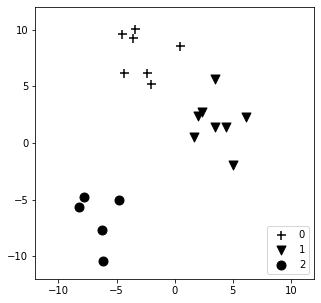

In [270]:
data = make_blobs(30, 2, centers=3, 
                  center_box=(-10, 10),
                    cluster_std=2,
                  random_state=42)

data_tr = data[0][:20]
labels_tr = data[1][:20]

# data_tr = make_blobs(20, 4, centers=3, 
#                   center_box=(-10, 10),
#                     cluster_std=1.5,
#                   random_state=42)
mark = ['+', 'v', 'o']
# Visualize dataset
plt.figure(figsize=(5, 5))
for i in range(3):
    plt.scatter(data_tr[labels_tr==i][:, 0],
                data_tr[labels_tr==i][:, 1],
                label=i, color='black', 
                marker=mark[i],
                s=81)
plt.ylim((-12, 12))
plt.xlim((-12, 12))
plt.title("")
plt.legend(loc=4)
plt.savefig('./label_tr.png', format='png')
plt.show()

[2 2 2 0 0 1 2 1 1 2]


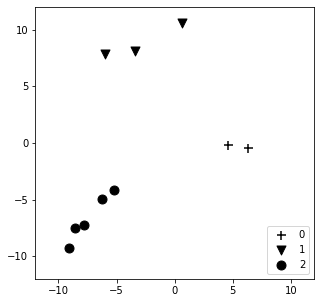

In [272]:
# data_ts = make_blobs(10, 4, centers=3, 
#                   center_box=(-10, 10),
#                   random_state=0,
#                     cluster_std=1)
data_ts = data[0][20:]
cllab = []
for i in data[1][20:]:
    if i!=2:
        cllab.append((i+1)%2)
    else:
        cllab.append(i)
cllab = np.array(cllab)
print(cllab)
mark = ['+', 'v', 'o']
# Visualize dataset
plt.figure(figsize=(5, 5))
for i in range(3):
    plt.scatter(data_ts[cllab==i][:, 0],
                data_ts[cllab==i][:, 1],
                label=i, 
                color='black', 
                marker=mark[i],
                s=81)
plt.ylim((-12, 12))
plt.xlim((-12, 12))
plt.title("")
plt.legend(loc=4)
plt.savefig('./label_ts.png', format='png')
plt.show()

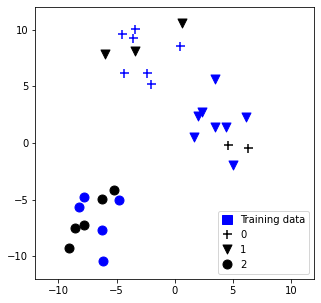

In [274]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(5, 5))
for i in range(3):
    plt1 = ax.scatter(data_tr[labels_tr==i][:, 0],
                data_tr[labels_tr==i][:, 1],
                label=i, color='blue', 
                marker=mark[i],
                s=81)
    plt2 = ax.scatter(data_ts[cllab==i][:, 0],
                data_ts[cllab==i][:, 1],
                label=i, 
                color='black', 
                marker=mark[i],
                s=81)

legend_el = [mpatches.Patch(color='blue', label='Training data'), 
             plt.scatter([],[], marker='+', label='0', color='black', s=81),
            plt.scatter([],[], marker='v', label='1', color='black', s=81),
            plt.scatter([],[], marker='o', label='2', color='black', s=81)]
plt.legend(handles=legend_el, handlelength=1, handleheight=1, loc=4)
plt.ylim((-12, 12))
plt.xlim((-12, 12))
plt.savefig('./label_all.png', format='png')
plt.show()

# data = np.append(data_tr[0], data_ts[0], axis=0)
# lab = np.append(data_tr[1], cllab)
# color = ['black'] * 20 + ['blue'] * 10
# plt.figure(figsize=(5, 5))
# for i in range(3):
#     plt.scatter(data[lab==i][:, 0],
#                 data[lab==i][:, 1],
#                 label=i, 
#                 color=color, 
#                 marker=mark[i],
#                 s=81)
# # plt.xlim((-5, 7))
# # plt.ylim((0, 12))
# plt.title("")
# plt.legend()
# # plt.savefig('./label_all.pdf', format='pdf')
# plt.show()

In [81]:
data.shape

(60,)

## Example 2: MNIST real-world dataset

In [12]:
# Example 3: MNIST dataset
# Load the dataset
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(int)

# Create training and test sets
X_tr, y_tr = mnist['data'][:60000], mnist.target[:60000]
X_ts, y_ts = mnist['data'][60000::], mnist.target[60000::]
transform = UMAP(n_components=2,
                 random_state=42,
                 n_neighbors=30,
                 min_dist=0.0)
X_tr = transform.fit_transform(X_tr)
X_ts = transform.transform(X_ts)

#Initialize classifier/clustering algorithms
combo = {'s': [KNeighborsClassifier(n_neighbors=30), SVC(), LogisticRegression(), RandomForestClassifier()],
         'c': [hdbscan.HDBSCAN(min_samples=10, min_cluster_size=200)]}

scsel = SCParamSelection(combo, 2, 10, 7, 10, list(range(2, 13)), y_tr)
scsel.fit(X_tr, 10)

07:56:44, INFO Running 4 combinations of classification/clustering methods...

10:34:28, INFO True number of clusters known: 10

10:34:28, INFO Best solution(s):
10:34:28, INFO Models: RandomForestClassifier()/HDBSCAN(min_cluster_size=200, min_samples=10))
10:34:28, INFO Validation performance: (0.05968012093459637, (0.05968012093459637, 0.05833983529739129))
10:34:28, INFO N clusters: 10



In [14]:
# s = KNeighborsClassifier(n_neighbors=30)
s = RandomForestClassifier()
c = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=200)

reval = FindBestClustCV(s=s,
                        c=c,
                        nfold=2,
                        nrand=10,
                        n_jobs=N_JOBS)

metrics, nclustbest, tr_lab = reval.best_nclust(X_tr, iter_cv=10, strat_vect=y_tr)

12:02:34, INFO Validation stability: (0.059683263881967534, (0.059683263881967534, 0.05833862642463629))


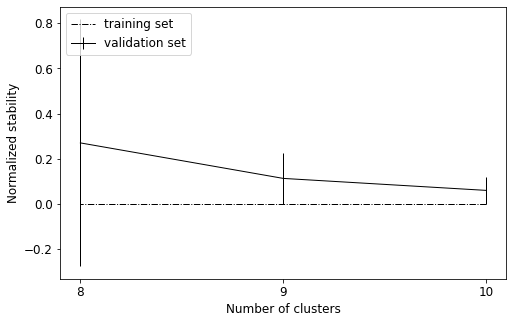

In [19]:
plot_metrics(metrics, save_fig='mnist_performance.png')
logging.info(f"Validation stability: {metrics['val'][nclustbest]}")

In [15]:
out = reval.evaluate(X_tr, X_ts, nclust=nclustbest, tr_lab=tr_lab)
perm_lab = kuhn_munkres_algorithm(y_ts, out.test_cllab)

logging.info(f"Best number of clusters during CV: {nclustbest}")
logging.info(f"Best number of clusters on test set: {len([lab for lab in np.unique(out.test_cllab) if lab >= 0])}")
logging.info(f'AMI (true labels vs predicted labels) = '
             f'{adjusted_mutual_info_score(y_ts, out.test_cllab)}')
logging.info('\n\n')

logging.info("Metrics from true label comparisons on test set:")
class_scores = compute_metrics(y_ts, perm_lab)
for k, val in class_scores.items():
    logging.info(f'{k}, {val}')
logging.info('\n\n')

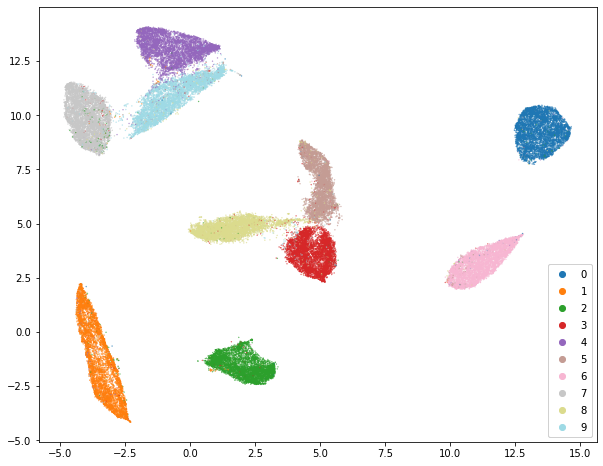

In [37]:
# Visualization
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(X_tr[:, 0],
                     X_tr[:, 1],
                     c=y_tr, 
                     cmap='tab20',
                     s=0.1)
legend = ax.legend(*scatter.legend_elements())
ax.add_artist(legend)
plt.title("")
plt.savefig('./mnist_train.png')
plt.show()

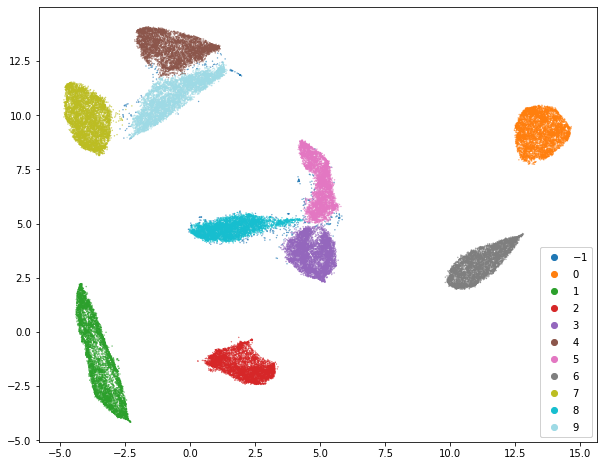

In [39]:
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(X_tr[:, 0],
                     X_tr[:, 1],
                     c=kuhn_munkres_algorithm(y_tr, tr_lab), 
                     cmap='tab20',
                     s=0.1)
legend = ax.legend(*scatter.legend_elements())
ax.add_artist(legend)
plt.title("")
plt.savefig('./mnist_trainreval.png')
plt.show()

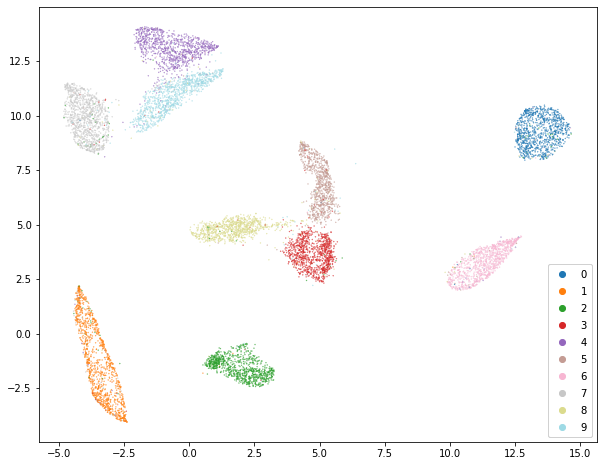

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(X_ts[:, 0],
                    X_ts[:, 1],
                    c=y_ts, cmap='tab20',
                    s=0.1)
legend = ax.legend(*scatter.legend_elements())
ax.add_artist(legend)
plt.title("")
plt.savefig('./mnist_test.png')
plt.show()

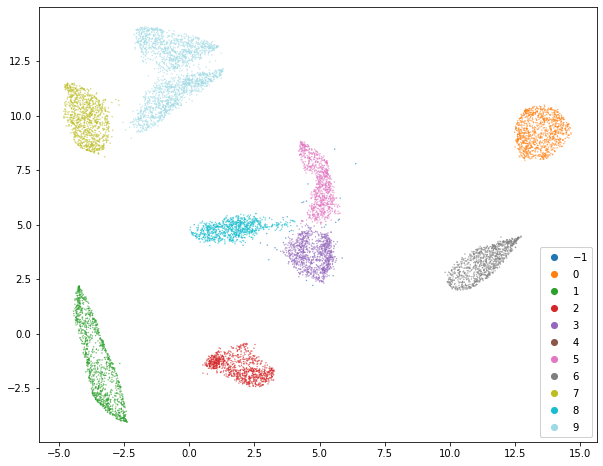

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(X_ts[:, 0],
                X_ts[:, 1],
                s=0.1,
                c=perm_lab, cmap='tab20')
legend = ax.legend(*scatter.legend_elements())
ax.add_artist(legend)
plt.title("")
plt.savefig('./mnist_testreval.png')
plt.show()

In [15]:
# Internal measures
# SILHOUETTE
logging.info("Silhouette score based selection")
sil_score_tr, sil_best_tr, sil_label_tr = select_best(X_tr, c, silhouette_score, select='max')
sil_score_ts, sil_best_ts, sil_label_ts = select_best(X_ts, c, silhouette_score, select='max')
logging.info(f"Best number of clusters (and scores) for tr/ts independent runs: {sil_best_tr}({sil_score_tr})/{sil_best_ts}({sil_score_ts})")
logging.info(f'AMI (true labels vs clustering labels) training = '
                 f'{adjusted_mutual_info_score(y_tr, kuhn_munkres_algorithm(y_tr, sil_label_tr))}')
logging.info(f'AMI (true labels vs clustering labels) test = '
                 f'{adjusted_mutual_info_score(y_ts, kuhn_munkres_algorithm(y_ts, sil_label_ts))}')
logging.info('\n\n')

# DAVIES-BOULDIN
logging.info("Davies-Bouldin score based selection")
db_score_tr, db_best_tr, db_label_tr = select_best(X_tr, c, davies_bouldin_score, 
                                        select='min')
db_score_ts, db_best_ts, db_label_ts = select_best(X_ts, c, davies_bouldin_score, 
                                        select='min')

logging.info(f"Best number of clusters (and scores) for tr/ts independent runs: {db_best_tr}({db_score_tr})/{db_best_ts}({db_score_ts})")
logging.info(f'AMI (true labels vs clustering labels) training = '
                 f'{adjusted_mutual_info_score(y_tr, kuhn_munkres_algorithm(y_tr, db_label_tr))}')
logging.info(f'AMI (true labels vs clustering labels) test = '
                 f'{adjusted_mutual_info_score(y_ts, kuhn_munkres_algorithm(y_ts, db_label_ts))}')
logging.info('\n\n')

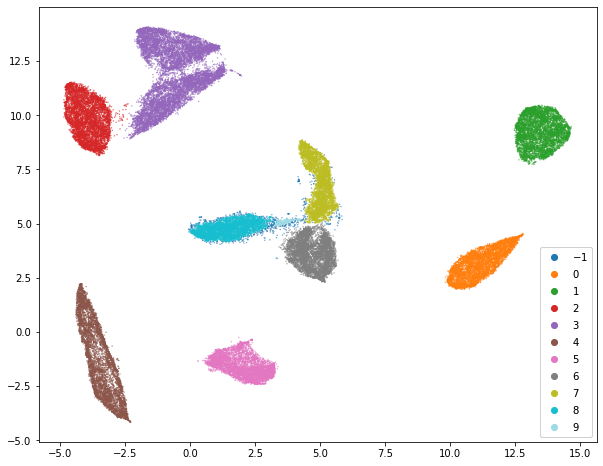

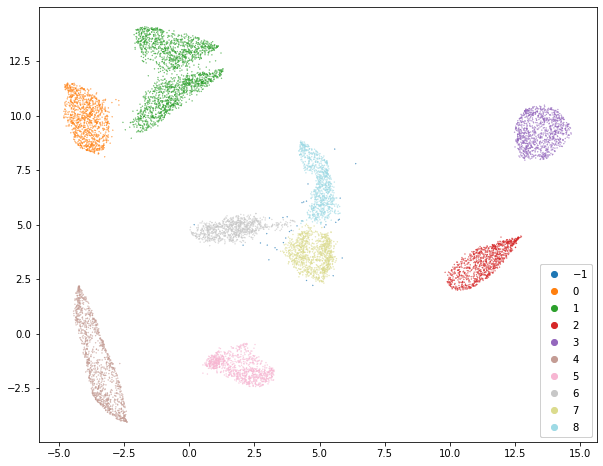

In [33]:
#Visualization
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(X_tr[:, 0],
                     X_tr[:, 1],
                     c=sil_label_tr, 
                     cmap='tab20',
                     s=0.1)
legend = ax.legend(*scatter.legend_elements())
ax.add_artist(legend)
plt.title("")
plt.savefig('./mnist_trainsilh.png')
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(X_ts[:, 0],
                     X_ts[:, 1],
                     c=sil_label_ts, 
                     cmap='tab20',
                     s=0.1)
legend = ax.legend(*scatter.legend_elements())
ax.add_artist(legend)
legend = ax.legend(*scatter.legend_elements())
ax.add_artist(legend)
plt.title("")
plt.savefig('./mnist_testsilh.png')
plt.show()

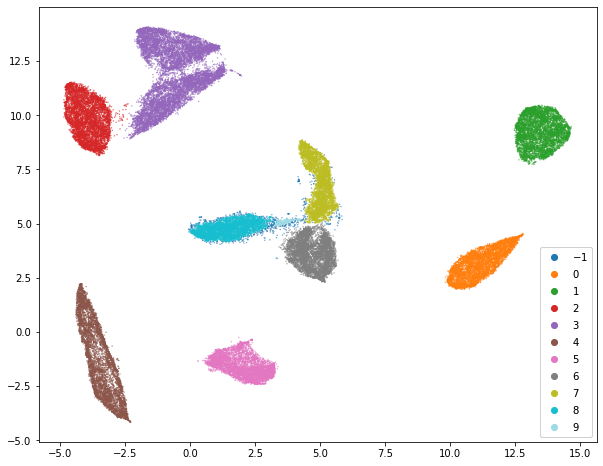

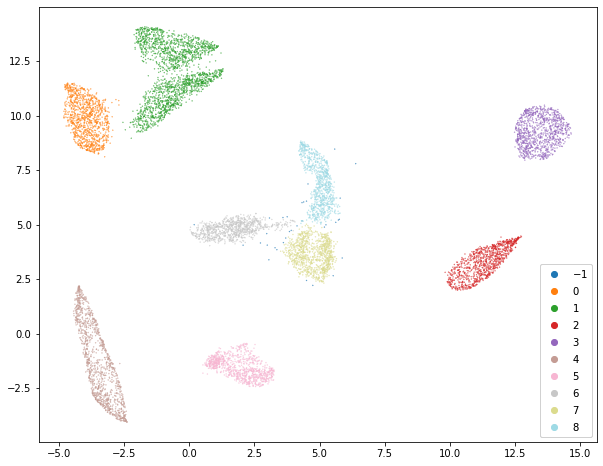

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(X_tr[:, 0],
                     X_tr[:, 1],
                     c=db_label_tr, 
                     cmap='tab20',
                     s=0.1)
legend = ax.legend(*scatter.legend_elements())
ax.add_artist(legend)
plt.title("")
plt.savefig('./mnist_traindb.png')
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(X_ts[:, 0],
                     X_ts[:, 1],
                     s=0.1,
                     c=db_label_ts, 
                     cmap='tab20')
legend = ax.legend(*scatter.legend_elements())
ax.add_artist(legend)
plt.title("")
plt.savefig('./mnist_testdb.png')
plt.show()

## Example 4: best clussifier/clustering combination search

In [2]:
# Import benchmark datasets
uci_data = build_ucidatasets()

In [6]:
# Example 4: best clussifier/clustering for UCI dataset

# Classifiers
s = [LogisticRegression(solver='liblinear',
                        random_state=42),
     RandomForestClassifier(n_estimators=100,
                            random_state=42),
     KNeighborsClassifier(n_neighbors=1,
                           metric='euclidean'),
     SVC(C=1,
         random_state=42)]

# Clustering
c = [AgglomerativeClustering(), 
     KMeans(random_state=42),
     hdbscan.HDBSCAN()]

scparam = {'s': s,
           'c': c}

transform = UMAP(n_neighbors=30, min_dist=0.0, random_state=42)
scale = StandardScaler()

# Run parameter selection algorithm
best_results = {}
for data, name in zip(uci_data, uci_data._fields):
    if name == 'hwdigits':
        scparam['s'][-1].gamma = (1 / data['data'].shape[0])
        nclass = len(np.unique(data['target']))
        logging.info(f"Processing dataset {name}")
        logging.info(f"True number of classes: {nclass}\n")
        X_tr, X_ts, y_tr, y_ts = train_test_split(data['data'],
                                                  data['target'],
                                                  test_size=0.40,
                                                  random_state=42,
                                                  stratify=data['target'])
        # Change here for different preprocessing
        X_tr = transform.fit_transform(X_tr)
        X_ts = transform.transform(X_ts)
        scparam_select = SCParamSelection(sc_params=scparam,
                                          cv=2,
                                          nrand=10,
                                          clust_range=list(range(2, nclass+3, 1)),
                                          n_jobs=N_JOBS,
                                          iter_cv=10,
                                          strat=y_tr)
        scparam_select.fit(X_tr, nclass=nclass)
        best_results[name] = scparam_select.best_param_
        # Uncomment to save the results
    #     pkl.dump(best_results, open('./best_resultUCI_scaledumap.pkl', 'wb'))
        logging.info('*' * 100)
        logging.info('\n\n')

19:11:56, INFO Processing dataset hwdigits
19:11:56, INFO True number of classes: 10

19:11:59, INFO Running 12 combinations of classification/clustering methods...

19:18:38, INFO True number of clusters known: 10

19:18:38, INFO Best solution(s):
19:18:38, INFO Models: RandomForestClassifier(random_state=42)/AgglomerativeClustering(n_clusters=10))
19:18:38, INFO Validation performance: (0.0, (0.0, 0.0))
19:18:38, INFO N clusters: 10

19:18:38, INFO Models: KNeighborsClassifier(metric='euclidean', n_neighbors=1)/AgglomerativeClustering(n_clusters=10))
19:18:38, INFO Validation performance: (0.0, (0.0, 0.0))
19:18:38, INFO N clusters: 10

19:18:38, INFO Models: RandomForestClassifier(random_state=42)/KMeans(n_clusters=10, random_state=42))
19:18:38, INFO Validation performance: (0.0, (0.0, 0.0))
19:18:38, INFO N clusters: 10

19:18:38, INFO Models: KNeighborsClassifier(metric='euclidean', n_neighbors=1)/KMeans(n_clusters=10, random_state=42))
19:18:38, INFO Validation performance: (0.0

In [8]:
uci_data.hwdigits.data.shape

(1797, 64)

In [9]:
# Function that fits the best models to the UCI datasets and reports the results
def test_ucibest(X_tr, X_ts, y_tr, y_ts, best_sol, 
                 n_jobs=1, preprocess=None, tr_lab=None):
    reval = FindBestClustCV(s=best_sol['s'],
                            c=best_sol['c'],
                            nfold=2,
                            nrand=10,
                            n_jobs=n_jobs)

    transform = UMAP(n_neighbors=30, min_dist=0.0, random_state=42)
    scale = StandardScaler()

    if preprocess == 'scaled':
        X_tr = scale.fit_transform(X_tr)
        X_ts = scale.transform(X_ts)
    elif preprocess == 'umap':
        X_tr = transform.fit_transform(X_tr)
        X_ts = transform.transform(X_ts)
    elif preprocess == 'scaled+umap':
        X_tr = transform.fit_transform(scale.fit_transform(X_tr))
        X_ts = transform.transform(scale.transform(X_ts))

    if isinstance(best_sol['c'], hdbscan.HDBSCAN):
        _, _, tr_lab = reval.best_nclust(X_tr, iter_cv=1, strat_vect=y_tr)
        
    out = reval.evaluate(X_tr, X_ts, nclust=best_sol['nclust'], tr_lab=tr_lab)
    perm_lab = kuhn_munkres_algorithm(y_ts, out.test_cllab)

    logging.info(f'Testing solution {best_sol}.')
    logging.info(f"Best number of clusters during CV: {best_sol['nclust']}")
    logging.info(f"Best number of clusters on test set: {len([lab for lab in np.unique(out.test_cllab) if lab >= 0])}")
    logging.info(f"Test set accuracy: {out.test_acc}")
    logging.info(f'AMI (true labels vs predicted labels) = '
                 f'{adjusted_mutual_info_score(y_ts, out.test_cllab)}')
    logging.info('\n\n')
    
    logging.info("Metrics from true label comparisons on test set:")
    class_scores = compute_metrics(y_ts, perm_lab)
    logging.info('\n\n')
    
    for k, val in class_scores.items():
        logging.info(f"{k}, {val}")

    # Internal measures
    # SILHOUETTE
    logging.info("Silhouette score based selection")
    sil_score_tr, sil_best_tr, sil_label_tr = select_best(X_tr, best_sol['c'], silhouette_score, select='max')
    sil_score_ts, sil_best_ts, sil_label_ts = select_best(X_ts, best_sol['c'], silhouette_score, select='max')
    logging.info(f"Best number of clusters (and scores) for tr/ts independent "
                 f"runs: {sil_best_tr}({sil_score_tr})/{sil_best_ts}({sil_score_ts})")
    logging.info(f'AMI (true labels vs clustering labels) training = '
                 f'{adjusted_mutual_info_score(y_tr, kuhn_munkres_algorithm(y_tr, sil_label_tr))}')
    logging.info(f'AMI (true labels vs clustering labels) test = '
                 f'{adjusted_mutual_info_score(y_ts, kuhn_munkres_algorithm(y_ts, sil_label_ts))}')
    logging.info(f"Silhouette metrics: {compute_metrics(y_ts, kuhn_munkres_algorithm(y_ts, sil_label_ts))}")
    logging.info('\n\\n')
    
    # DAVIES-BOULDIN
    logging.info("Davies-Bouldin score based selection")
    db_score_tr, db_best_tr, db_label_tr = select_best(X_tr, best_sol['c'], davies_bouldin_score,
                                                       select='min')
    db_score_ts, db_best_ts, db_label_ts = select_best(X_ts, best_sol['c'], davies_bouldin_score,
                                                       select='min')

    logging.info(f"Best number of clusters (and scores) for tr/ts independent "
                 f"runs: {db_best_tr}({db_score_tr})/{db_best_ts}({db_score_ts})")
    logging.info(f'AMI (true labels vs clustering labels) training = '
                 f'{adjusted_mutual_info_score(y_tr, kuhn_munkres_algorithm(y_tr, db_label_tr))}')
    logging.info(f'AMI (true labels vs clustering labels) test = '
                 f'{adjusted_mutual_info_score(y_ts, kuhn_munkres_algorithm(y_ts, db_label_ts))}')
    logging.info(f"Davies-Bouldin metrics: {compute_metrics(y_ts, kuhn_munkres_algorithm(y_ts, db_label_ts))}")
    logging.info('\n\n')

## Best solutions with raw data
Dataset whose best solutions don't require preprocessing are: biodeg, breastwi, ionosphere, seeds, and forest.

In [4]:
# Read pkl objects with best solutions
best_raw = pkl.load(open('../best_resultUCI_raw.pkl', 'rb'))

### `biodeg` dataset

In [5]:
biodeg_best = {'s': best_raw['biodeg'][0][0],
               'c': best_raw['biodeg'][0][1],
               'nclust': best_raw['biodeg'][0][2]}
biodeg_tr, biodeg_ts, biodeg_y_tr, biodeg_y_ts = train_test_split(uci_data.biodeg['data'],
                                                                  uci_data.biodeg['target'],
                                                                  test_size=0.40,
                                                                  random_state=42,
                                                                  stratify=uci_data.biodeg['target'])
test_ucibest(biodeg_tr, biodeg_ts, biodeg_y_tr, biodeg_y_ts, biodeg_best, n_jobs=7)

18:21:11, INFO Testing solution {'s': KNeighborsClassifier(metric='euclidean', n_neighbors=1), 'c': KMeans(n_clusters=2, random_state=42), 'nclust': 2}.
18:21:11, INFO Best number of clusters during CV: 2
18:21:11, INFO Best number of clusters on test set: 2
18:21:11, INFO Test set accuracy: 0.990521327014218
18:21:11, INFO AMI (true labels vs predicted labels) = -0.0018652218961679064
18:21:11, INFO 


18:21:11, INFO Metrics from true label comparisons on test set:
18:21:11, INFO 


18:21:11, INFO ACC, 0.5829383886255924
18:21:11, INFO MCC, 0.011261506794041351
18:21:11, INFO F1, 0.30158730158730157
18:21:11, INFO precision, 0.34545454545454546
18:21:11, INFO recall, 0.2676056338028169
18:21:11, INFO Silhouette score based selection
18:21:11, INFO Best number of clusters (and scores) for tr/ts independent runs: 2(0.3945620090548716)/2(0.3786704746384278)
18:21:11, INFO AMI (true labels vs clustering labels) training = -0.0012019363243028396
18:21:11, INFO AMI (true labels vs clusterin

### `breastwi` dataset

In [6]:
breast_best = {'s': best_raw['breastwi'][0][0],
               'c': best_raw['breastwi'][0][1],
               'nclust': best_raw['breastwi'][0][2]}
breast_tr, breast_ts, breast_y_tr, breast_y_ts = train_test_split(uci_data.breastwi['data'],
                                                                  uci_data.breastwi['target'],
                                                                  test_size=0.40,
                                                                  random_state=42,
                                                                  stratify=uci_data.breastwi['target'])
test_ucibest(breast_tr, breast_ts, breast_y_tr, breast_y_ts, breast_best, n_jobs=7)

18:23:07, INFO Testing solution {'s': SVC(C=1, gamma=0.0014641288433382138, random_state=42), 'c': KMeans(n_clusters=2, random_state=42), 'nclust': 2}.
18:23:07, INFO Best number of clusters during CV: 2
18:23:07, INFO Best number of clusters on test set: 2
18:23:07, INFO Test set accuracy: 0.9890510948905109
18:23:07, INFO AMI (true labels vs predicted labels) = 0.7619729809357038
18:23:07, INFO 


18:23:07, INFO Metrics from true label comparisons on test set:
18:23:07, INFO 


18:23:07, INFO ACC, 0.9635036496350365
18:23:07, INFO MCC, 0.9203268606525232
18:23:07, INFO F1, 0.9484536082474228
18:23:07, INFO precision, 0.9387755102040817
18:23:07, INFO recall, 0.9583333333333334
18:23:07, INFO Silhouette score based selection
18:23:08, INFO Best number of clusters (and scores) for tr/ts independent runs: 2(0.5895642112362032)/2(0.6080747591303565)
18:23:08, INFO AMI (true labels vs clustering labels) training = 0.7839042569082982
18:23:08, INFO AMI (true labels vs clustering labels) te

### `ionosphere` dataset

In [7]:
ionosphere_best = {'s': best_raw['ionosphere'][0][0],
               'c': best_raw['ionosphere'][0][1],
               'nclust': best_raw['ionosphere'][0][2]}
ionosphere_tr, ionosphere_ts, ionosphere_y_tr, ionosphere_y_ts = train_test_split(uci_data.ionosphere['data'],
                                                                  uci_data.ionosphere['target'],
                                                                  test_size=0.40,
                                                                  random_state=42,
                                                                  stratify=uci_data.ionosphere['target'])
test_ucibest(ionosphere_tr, ionosphere_ts, ionosphere_y_tr, ionosphere_y_ts, ionosphere_best, n_jobs=7)

18:23:37, INFO Testing solution {'s': SVC(C=1, gamma=0.002849002849002849, random_state=42), 'c': KMeans(n_clusters=2, random_state=42), 'nclust': 2}.
18:23:37, INFO Best number of clusters during CV: 2
18:23:37, INFO Best number of clusters on test set: 2
18:23:37, INFO Test set accuracy: 0.9929078014184397
18:23:37, INFO AMI (true labels vs predicted labels) = 0.20808109267301894
18:23:37, INFO 


18:23:37, INFO Metrics from true label comparisons on test set:
18:23:37, INFO 


18:23:37, INFO ACC, 0.7659574468085106
18:23:37, INFO MCC, 0.5226194503849392
18:23:37, INFO F1, 0.7079646017699115
18:23:37, INFO precision, 0.6451612903225806
18:23:37, INFO recall, 0.7843137254901961
18:23:37, INFO Silhouette score based selection
18:23:37, INFO Best number of clusters (and scores) for tr/ts independent runs: 2(0.28989694503111246)/2(0.30371381985271556)
18:23:37, INFO AMI (true labels vs clustering labels) training = 0.09054155848268139
18:23:37, INFO AMI (true labels vs clustering labels)

### `seeds` dataset

In [8]:
seeds_best = {'s': best_raw['seeds'][0][0],
               'c': best_raw['seeds'][0][1],
               'nclust': best_raw['seeds'][0][2]}
seeds_tr, seeds_ts, seeds_y_tr, seeds_y_ts = train_test_split(uci_data.seeds['data'],
                                                                  uci_data.seeds['target'],
                                                                  test_size=0.40,
                                                                  random_state=42,
                                                                  stratify=uci_data.seeds['target'])
test_ucibest(seeds_tr, seeds_ts, seeds_y_tr, seeds_y_ts, seeds_best, n_jobs=7)

18:23:56, INFO Testing solution {'s': SVC(C=1, gamma=0.004761904761904762, random_state=42), 'c': KMeans(n_clusters=3, random_state=42), 'nclust': 3}.
18:23:56, INFO Best number of clusters during CV: 3
18:23:56, INFO Best number of clusters on test set: 3
18:23:56, INFO Test set accuracy: 0.8928571428571429
18:23:56, INFO AMI (true labels vs predicted labels) = 0.6636150517231209
18:23:56, INFO 


18:23:56, INFO Metrics from true label comparisons on test set:
18:23:56, INFO 


18:23:56, INFO ACC, 0.8928571428571429
18:23:56, INFO MCC, 0.840896113683303
18:23:56, INFO F1, 0.8938964776828543
18:23:56, INFO precision, 0.8983410138248847
18:23:56, INFO recall, 0.8928571428571429
18:23:56, INFO Silhouette score based selection
18:23:56, INFO Best number of clusters (and scores) for tr/ts independent runs: 3(0.4949954175974562)/3(0.4406309763731152)
18:23:56, INFO AMI (true labels vs clustering labels) training = 0.7539752421640595
18:23:56, INFO AMI (true labels vs clustering labels) test

### `forest` dataset

In [9]:
forest_best = {'s': best_raw['forest'][0][0],
               'c': best_raw['forest'][0][1],
               'nclust': best_raw['forest'][0][2]}
forest_tr, forest_ts, forest_y_tr, forest_y_ts = train_test_split(uci_data.forest['data'],
                                                                  uci_data.forest['target'],
                                                                  test_size=0.40,
                                                                  random_state=42,
                                                                  stratify=uci_data.forest['target'])
test_ucibest(forest_tr, forest_ts, forest_y_tr, forest_y_ts, forest_best, n_jobs=7)

18:24:26, INFO Testing solution {'s': KNeighborsClassifier(metric='euclidean', n_neighbors=1), 'c': AgglomerativeClustering(n_clusters=4), 'nclust': 4}.
18:24:26, INFO Best number of clusters during CV: 4
18:24:26, INFO Best number of clusters on test set: 4
18:24:26, INFO Test set accuracy: 0.8809523809523809
18:24:26, INFO AMI (true labels vs predicted labels) = 0.5535850710592597
18:24:26, INFO 


18:24:26, INFO Metrics from true label comparisons on test set:
18:24:26, INFO 


18:24:26, INFO ACC, 0.7904761904761904
18:24:26, INFO MCC, 0.7183770123466835
18:24:26, INFO F1, 0.7972999456501078
18:24:26, INFO precision, 0.8560606060606061
18:24:26, INFO recall, 0.772175740925741
18:24:26, INFO Silhouette score based selection
18:24:26, INFO Best number of clusters (and scores) for tr/ts independent runs: 4(0.3017625998637281)/4(0.3039518511874156)
18:24:26, INFO AMI (true labels vs clustering labels) training = 0.5942190826135002
18:24:26, INFO AMI (true labels vs clustering labels) te

## Best solutions with UMAP preprocessed data
Datasets that require uniform manifold approximation and projection (UMAP) preprocessing are: iris, liver, movement, wholesale, ecoli, transfusion.

In [10]:
# Read pkl objects with best solutions
best_umap = pkl.load(open('../best_resultUCI_umap.pkl', 'rb'))

### `hwdigits` dataset

In [10]:
hwdigits_best = {'s': best_umap['hwdigits'][0][0],
                 'c': best_umap['hwdigits'][0][1],
                 'nclust': best_umap['hwdigits'][0][2]}

hwdigits_tr, hwdigits_ts, hwdigits_y_tr, hwdigits_y_ts = train_test_split(uci_data.hwdigits['data'],
                                                                          uci_data.hwdigits['target'],
                                                                          test_size=0.40,
                                                                          random_state=42,
                                                                          stratify=uci_data.hwdigits['target'])

test_ucibest(hwdigits_tr, hwdigits_ts, hwdigits_y_tr, hwdigits_y_ts, hwdigits_best, preprocess='umap', n_jobs=7)

19:26:55, INFO Testing solution {'s': KNeighborsClassifier(n_neighbors=1), 'c': KMeans(n_clusters=10), 'nclust': 10}.
19:26:55, INFO Best number of clusters during CV: 10
19:26:55, INFO Best number of clusters on test set: 10
19:26:55, INFO Test set accuracy: 0.9986091794158554
19:26:55, INFO AMI (true labels vs predicted labels) = 0.7632785714491545
19:26:55, INFO 


19:26:55, INFO Metrics from true label comparisons on test set:
19:26:55, INFO 


19:26:55, INFO ACC, 0.8191933240611962
19:26:55, INFO MCC, 0.8018821544958511
19:26:55, INFO F1, 0.8136824518983297
19:26:55, INFO precision, 0.8361215257278742
19:26:55, INFO recall, 0.8204452820423299
19:26:55, INFO Silhouette score based selection
19:26:55, INFO Best number of clusters (and scores) for tr/ts independent runs: 10(0.7359792590141296)/10(0.7502796053886414)
19:26:55, INFO AMI (true labels vs clustering labels) training = 0.8144996593382994
19:26:55, INFO AMI (true labels vs clustering labels) test = 0.7632785714491543
19:26:

### `iris` dataset

In [11]:
iris_best = {'s': best_umap['iris'][0][0],
               'c': best_umap['iris'][0][1],
               'nclust': best_umap['iris'][0][2]}
iris_tr, iris_ts, iris_y_tr, iris_y_ts = train_test_split(uci_data.iris['data'],
                                                                  uci_data.iris['target'],
                                                                  test_size=0.40,
                                                                  random_state=42,
                                                                  stratify=uci_data.iris['target'])

test_ucibest(iris_tr, iris_ts, iris_y_tr, iris_y_ts, iris_best, preprocess='umap', n_jobs=7)

18:24:54, INFO Testing solution {'s': RandomForestClassifier(random_state=42), 'c': HDBSCAN(), 'nclust': 3}.
18:24:54, INFO Best number of clusters during CV: 3
18:24:54, INFO Best number of clusters on test set: 2
18:24:54, INFO Test set accuracy: 0.8833333333333333
18:24:54, INFO AMI (true labels vs predicted labels) = 0.7282385897985907
18:24:54, INFO 


18:24:54, INFO Metrics from true label comparisons on test set:
18:24:54, INFO 


18:24:54, INFO ACC, 0.6666666666666666
18:24:54, INFO MCC, 0.6123724356957945
18:24:54, INFO F1, 0.5555555555555555
18:24:54, INFO precision, 0.5
18:24:54, INFO recall, 0.6666666666666666
18:24:54, INFO Silhouette score based selection
18:24:54, INFO Best number of clusters (and scores) for tr/ts independent runs: 4(0.7648069858551025)/2(0.9308299422264099)
18:24:54, INFO AMI (true labels vs clustering labels) training = 0.7505968200277202
18:24:54, INFO AMI (true labels vs clustering labels) test = 0.7282385897985907
18:24:54, INFO Silhouette metrics:

### `liver` dataset

In [12]:
liver_best = {'s': best_umap['liver'][0][0],
               'c': best_umap['liver'][0][1],
               'nclust': best_umap['liver'][0][2]}
liver_tr, liver_ts, liver_y_tr, liver_y_ts = train_test_split(uci_data.liver['data'],
                                                                  uci_data.liver['target'],
                                                                  test_size=0.40,
                                                                  random_state=42,
                                                                  stratify=uci_data.liver['target'])
test_ucibest(liver_tr, liver_ts, liver_y_tr, liver_y_ts, liver_best, 
             preprocess='umap', n_jobs=7)

18:25:29, INFO Testing solution {'s': KNeighborsClassifier(metric='euclidean', n_neighbors=1), 'c': KMeans(n_clusters=2, random_state=42), 'nclust': 2}.
18:25:29, INFO Best number of clusters during CV: 2
18:25:29, INFO Best number of clusters on test set: 2
18:25:29, INFO Test set accuracy: 0.9202898550724637
18:25:29, INFO AMI (true labels vs predicted labels) = 0.03491171737099566
18:25:29, INFO 


18:25:29, INFO Metrics from true label comparisons on test set:
18:25:29, INFO 


18:25:29, INFO ACC, 0.6159420289855072
18:25:29, INFO MCC, 0.23405536260702517
18:25:29, INFO F1, 0.6015037593984962
18:25:29, INFO precision, 0.6349206349206349
18:25:29, INFO recall, 0.5714285714285714
18:25:29, INFO Silhouette score based selection
18:25:29, INFO Best number of clusters (and scores) for tr/ts independent runs: 2(0.4536987841129303)/2(0.4909319579601288)
18:25:29, INFO AMI (true labels vs clustering labels) training = 0.023032934008930393
18:25:29, INFO AMI (true labels vs clustering label

### `movement` dataset

In [13]:
movement_best = {'s': best_umap['movement'][0][0],
               'c': best_umap['movement'][0][1],
               'nclust': best_umap['movement'][0][2]}
movement_tr, movement_ts, movement_y_tr, movement_y_ts = train_test_split(uci_data.movement['data'],
                                                                  uci_data.movement['target'],
                                                                  test_size=0.40,
                                                                  random_state=42,
                                                                  stratify=uci_data.movement['target'])
test_ucibest(movement_tr, movement_ts, movement_y_tr, movement_y_ts, movement_best, 
             preprocess='umap', n_jobs=7)

18:25:59, INFO Testing solution {'s': KNeighborsClassifier(metric='euclidean', n_neighbors=1), 'c': AgglomerativeClustering(n_clusters=6), 'nclust': 6}.
18:25:59, INFO Best number of clusters during CV: 6
18:25:59, INFO Best number of clusters on test set: 6
18:25:59, INFO Test set accuracy: 0.8958333333333334
18:25:59, INFO AMI (true labels vs predicted labels) = 0.4161855078175672
18:25:59, INFO 


18:25:59, INFO Metrics from true label comparisons on test set:
18:25:59, INFO 


18:25:59, INFO ACC, 0.3194444444444444
18:25:59, INFO MCC, 0.2951016663755466
18:25:59, INFO F1, 0.19438825757601855
18:25:59, INFO precision, 0.14516883676547543
18:25:59, INFO recall, 0.32296296296296295
18:25:59, INFO Silhouette score based selection
18:25:59, INFO Best number of clusters (and scores) for tr/ts independent runs: 6(0.6329535245895386)/6(0.4821399450302124)
18:25:59, INFO AMI (true labels vs clustering labels) training = 0.4818923827272918
18:25:59, INFO AMI (true labels vs clustering labels

### `wholesale` dataset

In [14]:
wholesale_best = {'s': best_umap['wholesale'][0][0],
               'c': best_umap['wholesale'][0][1],
               'nclust': best_umap['wholesale'][0][2]}
wholesale_tr, wholesale_ts, wholesale_y_tr, wholesale_y_ts = train_test_split(uci_data.wholesale['data'],
                                                                  uci_data.wholesale['target'],
                                                                  test_size=0.40,
                                                                  random_state=42,
                                                                  stratify=uci_data.wholesale['target'])
test_ucibest(wholesale_tr, wholesale_ts, wholesale_y_tr, wholesale_y_ts, wholesale_best, 
             preprocess='umap', n_jobs=7)

18:26:21, INFO Testing solution {'s': SVC(C=1, gamma=0.0022727272727272726, random_state=42), 'c': KMeans(n_clusters=3, random_state=42), 'nclust': 3}.
18:26:21, INFO Best number of clusters during CV: 3
18:26:21, INFO Best number of clusters on test set: 3
18:26:21, INFO Test set accuracy: 0.9659090909090909
18:26:21, INFO AMI (true labels vs predicted labels) = 0.002198228117539643
18:26:21, INFO 


18:26:21, INFO Metrics from true label comparisons on test set:
18:26:21, INFO 


18:26:21, INFO ACC, 0.3693181818181818
18:26:21, INFO MCC, 0.09289711908738942
18:26:21, INFO F1, 0.334085097484966
18:26:21, INFO precision, 0.3833458967787326
18:26:21, INFO recall, 0.43312582531597815
18:26:21, INFO Silhouette score based selection
18:26:22, INFO Best number of clusters (and scores) for tr/ts independent runs: 3(0.5459712743759155)/3(0.5406104922294617)
18:26:22, INFO AMI (true labels vs clustering labels) training = -0.003482173188076088
18:26:22, INFO AMI (true labels vs clustering labe

### `ecoli` dataset

In [15]:
ecoli_best = {'s': best_umap['ecoli'][-2][0],
               'c': best_umap['ecoli'][-2][1],
               'nclust': best_umap['ecoli'][-2][2]}
ecoli_tr, ecoli_ts, ecoli_y_tr, ecoli_y_ts = train_test_split(uci_data.ecoli['data'],
                                                                  uci_data.ecoli['target'],
                                                                  test_size=0.40,
                                                                  random_state=42,
                                                                  stratify=uci_data.ecoli['target'])
test_ucibest(ecoli_tr, ecoli_ts, ecoli_y_tr, ecoli_y_ts, ecoli_best, 
             preprocess='umap', n_jobs=7)

18:26:45, INFO Testing solution {'s': KNeighborsClassifier(metric='euclidean', n_neighbors=1), 'c': KMeans(n_clusters=2, random_state=42), 'nclust': 2}.
18:26:45, INFO Best number of clusters during CV: 2
18:26:45, INFO Best number of clusters on test set: 2
18:26:45, INFO Test set accuracy: 1.0
18:26:45, INFO AMI (true labels vs predicted labels) = 0.4804781817836936
18:26:45, INFO 


18:26:45, INFO Metrics from true label comparisons on test set:
18:26:45, INFO 


18:26:45, INFO ACC, 0.6222222222222222
18:26:45, INFO MCC, 0.464585735606162
18:26:45, INFO F1, 0.18746575342465754
18:26:45, INFO precision, 0.15697004608294932
18:26:45, INFO recall, 0.2338709677419355
18:26:45, INFO Silhouette score based selection
18:26:45, INFO Best number of clusters (and scores) for tr/ts independent runs: 2(0.7521242499351501)/2(0.7192690372467041)
18:26:45, INFO AMI (true labels vs clustering labels) training = 0.47384726703571917
18:26:45, INFO AMI (true labels vs clustering labels) test = 0.48047

### `transfusion` dataset

In [16]:
transfusion_best = {'s': best_umap['transfusion'][-2][0],
               'c': best_umap['transfusion'][-2][1],
               'nclust': best_umap['transfusion'][-2][2]}
transfusion_tr, transfusion_ts, transfusion_y_tr, transfusion_y_ts = train_test_split(uci_data.transfusion['data'],
                                                                  uci_data.transfusion['target'],
                                                                  test_size=0.40,
                                                                  random_state=42,
                                                                  stratify=uci_data.transfusion['target'])
test_ucibest(transfusion_tr, transfusion_ts, transfusion_y_tr, transfusion_y_ts, transfusion_best, 
             preprocess='umap', n_jobs=7)

/Users/landii03/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
18:27:09, INFO Testing solution {'s': KNeighborsClassifier(metric='euclidean', n_neighbors=1), 'c': KMeans(n_clusters=2, random_state=42), 'nclust': 2}.
18:27:09, INFO Best number of clusters during CV: 2
18:27:09, INFO Best number of clusters on test set: 2
18:27:09, INFO Test set accuracy: 1.0
18:27:09, INFO AMI (true labels vs predicted labels) = -0.0004219461126146571
18:27:09, INFO 


18:27:09, INFO Metrics from true label comparisons on test set:
18:27:09, INFO 


18:27:09, INFO ACC, 0.5366666666666666
18:27:09, INFO MCC, 0.05330011509128942
18:27:09, INFO F1, 0.3474178403755869
18:27:09, INFO precision, 0.2605633802816901
18:27:09, INFO recall, 0.5211267605633803
18:27:09, INFO Silhouette score based selection
18:27

## Best solutions with scaled data
Datasets: glass, leaf.

In [17]:
# Read pkl objects with best solutions
best_scaled = pkl.load(open('../best_resultUCI_scaled.pkl', 'rb'))

### `glass` dataset

In [18]:
glass_best = {'s': best_scaled['glass'][0][0],
               'c': best_scaled['glass'][0][1],
               'nclust': best_scaled['glass'][0][2]}
glass_tr, glass_ts, glass_y_tr, glass_y_ts = train_test_split(uci_data.glass['data'],
                                                                  uci_data.glass['target'],
                                                                  test_size=0.40,
                                                                  random_state=42,
                                                                  stratify=uci_data.glass['target'])
test_ucibest(glass_tr, glass_ts, glass_y_tr, glass_y_ts, glass_best, 
             preprocess='scaled', n_jobs=7)

18:27:31, INFO Testing solution {'s': KNeighborsClassifier(metric='euclidean', n_neighbors=1), 'c': KMeans(n_clusters=3, random_state=42), 'nclust': 3}.
18:27:31, INFO Best number of clusters during CV: 3
18:27:31, INFO Best number of clusters on test set: 3
18:27:31, INFO Test set accuracy: 0.7325581395348837
18:27:31, INFO AMI (true labels vs predicted labels) = 0.3519426345126818
18:27:31, INFO 


18:27:31, INFO Metrics from true label comparisons on test set:
18:27:31, INFO 


18:27:31, INFO ACC, 0.46511627906976744
18:27:31, INFO MCC, 0.3498521731605121
18:27:31, INFO F1, 0.2988122988122988
18:27:31, INFO precision, 0.32010582010582006
18:27:31, INFO recall, 0.37222222222222223
18:27:31, INFO Silhouette score based selection
18:27:31, INFO Best number of clusters (and scores) for tr/ts independent runs: 3(0.40639856261067064)/3(0.39748570971273534)
18:27:31, INFO AMI (true labels vs clustering labels) training = 0.23092175787561292
18:27:31, INFO AMI (true labels vs clustering lab

### `leaf` dataset

In [19]:
leaf_best = {'s': best_scaled['leaf'][0][0],
               'c': best_scaled['leaf'][0][1],
               'nclust': best_scaled['leaf'][0][2]}
leaf_tr, leaf_ts, leaf_y_tr, leaf_y_ts = train_test_split(uci_data.leaf['data'],
                                                                  uci_data.leaf['target'],
                                                                  test_size=0.40,
                                                                  random_state=42,
                                                                  stratify=uci_data.leaf['target'])
test_ucibest(leaf_tr, leaf_ts, leaf_y_tr, leaf_y_ts, leaf_best, 
             preprocess='scaled', n_jobs=7)

18:27:58, INFO Testing solution {'s': RandomForestClassifier(random_state=42), 'c': KMeans(n_clusters=3, random_state=42), 'nclust': 3}.
18:27:58, INFO Best number of clusters during CV: 3
18:27:58, INFO Best number of clusters on test set: 3
18:27:58, INFO Test set accuracy: 0.9117647058823529
18:27:58, INFO AMI (true labels vs predicted labels) = 0.2186518074302217
18:27:58, INFO 


18:27:58, INFO Metrics from true label comparisons on test set:
18:27:58, INFO 


18:27:58, INFO ACC, 0.11764705882352941
18:27:58, INFO MCC, 0.10576722185427641
18:27:58, INFO F1, 0.027956414912936652
18:27:58, INFO precision, 0.017513498152884343
18:27:58, INFO recall, 0.1
18:27:58, INFO Silhouette score based selection
18:27:58, INFO Best number of clusters (and scores) for tr/ts independent runs: 3(0.3407288260373285)/3(0.329630224845605)
18:27:58, INFO AMI (true labels vs clustering labels) training = 0.22438753714257306
18:27:59, INFO AMI (true labels vs clustering labels) test = 0.2186518074302217


## Best solutions with scaled+UMAP preprocessed data
Datasets: climate, banknote, parkinsons, yeast, urban.

In [20]:
# Read pkl objects with best solutions
best_scaledumap = pkl.load(open('../best_resultUCI_scaledumap.pkl', 'rb'))

### `climate` dataset

In [21]:
climate_best = {'s': best_scaledumap['climate'][0][0],
               'c': best_scaledumap['climate'][0][1],
               'nclust': best_scaledumap['climate'][0][2]}
climate_tr, climate_ts, climate_y_tr, climate_y_ts = train_test_split(uci_data.climate['data'],
                                                                  uci_data.climate['target'],
                                                                  test_size=0.40,
                                                                  random_state=42,
                                                                  stratify=uci_data.climate['target'])
test_ucibest(climate_tr, climate_ts, climate_y_tr, climate_y_ts, climate_best, 
             preprocess='scaled+umap', n_jobs=7)

18:28:18, INFO Testing solution {'s': KNeighborsClassifier(metric='euclidean', n_neighbors=1), 'c': KMeans(n_clusters=2, random_state=42), 'nclust': 2}.
18:28:18, INFO Best number of clusters during CV: 2
18:28:18, INFO Best number of clusters on test set: 2
18:28:18, INFO Test set accuracy: 0.5046296296296297
18:28:18, INFO AMI (true labels vs predicted labels) = -0.0046105782446724825
18:28:18, INFO 


18:28:18, INFO Metrics from true label comparisons on test set:
18:28:18, INFO 


18:28:18, INFO ACC, 0.5277777777777778
18:28:18, INFO MCC, 0.016776539984043038
18:28:18, INFO F1, 0.673076923076923
18:28:18, INFO precision, 0.9210526315789473
18:28:18, INFO recall, 0.5303030303030303
18:28:18, INFO Silhouette score based selection
18:28:18, INFO Best number of clusters (and scores) for tr/ts independent runs: 2(0.3780439496040344)/2(0.49217090010643005)
18:28:18, INFO AMI (true labels vs clustering labels) training = -0.001754574700910101
18:28:18, INFO AMI (true labels vs clustering 

### `banknote` dataset

In [22]:
banknote_best = {'s': best_scaledumap['banknote'][0][0],
               'c': best_scaledumap['banknote'][0][1],
               'nclust': best_scaledumap['banknote'][0][2]}
banknote_tr, banknote_ts, banknote_y_tr, banknote_y_ts = train_test_split(uci_data.banknote['data'],
                                                                  uci_data.banknote['target'],
                                                                  test_size=0.40,
                                                                  random_state=42,
                                                                  stratify=uci_data.banknote['target'])
test_ucibest(banknote_tr, banknote_ts, banknote_y_tr, banknote_y_ts, banknote_best, 
             preprocess='scaled+umap', n_jobs=7)

18:28:49, INFO Testing solution {'s': SVC(C=1, gamma=0.0007288629737609329, random_state=42), 'c': AgglomerativeClustering(), 'nclust': 2}.
18:28:49, INFO Best number of clusters during CV: 2
18:28:49, INFO Best number of clusters on test set: 2
18:28:49, INFO Test set accuracy: 1.0
18:28:49, INFO AMI (true labels vs predicted labels) = 0.9337102100359516
18:28:49, INFO 


18:28:49, INFO Metrics from true label comparisons on test set:
18:28:49, INFO 


18:28:49, INFO ACC, 0.9908925318761385
18:28:49, INFO MCC, 0.9817613873476319
18:28:49, INFO F1, 0.9898580121703854
18:28:49, INFO precision, 0.9799196787148594
18:28:49, INFO recall, 1.0
18:28:49, INFO Silhouette score based selection
18:28:49, INFO Best number of clusters (and scores) for tr/ts independent runs: 2(0.5527928471565247)/2(0.5510127544403076)
18:28:49, INFO AMI (true labels vs clustering labels) training = 0.9372730460648924
18:28:49, INFO AMI (true labels vs clustering labels) test = 0.9337102100359516
18:28:49, INFO Sil

### `parkinsons` dataset

In [23]:
parkinsons_best = {'s': best_scaledumap['parkinsons'][0][0],
               'c': best_scaledumap['parkinsons'][0][1],
               'nclust': best_scaledumap['parkinsons'][0][2]}
parkinsons_tr, parkinsons_ts, parkinsons_y_tr, parkinsons_y_ts = train_test_split(uci_data.parkinsons['data'],
                                                                  uci_data.parkinsons['target'],
                                                                  test_size=0.40,
                                                                  random_state=42,
                                                                  stratify=uci_data.parkinsons['target'])
test_ucibest(parkinsons_tr, parkinsons_ts, parkinsons_y_tr, parkinsons_y_ts, parkinsons_best, 
             preprocess='scaled+umap', n_jobs=7)

18:29:16, INFO Testing solution {'s': KNeighborsClassifier(metric='euclidean', n_neighbors=1), 'c': KMeans(n_clusters=2, random_state=42), 'nclust': 2}.
18:29:16, INFO Best number of clusters during CV: 2
18:29:16, INFO Best number of clusters on test set: 2
18:29:16, INFO Test set accuracy: 0.9615384615384616
18:29:16, INFO AMI (true labels vs predicted labels) = 0.09474306561929872
18:29:16, INFO 


18:29:16, INFO Metrics from true label comparisons on test set:
18:29:16, INFO 


18:29:16, INFO ACC, 0.6282051282051282
18:29:16, INFO MCC, 0.3456478118521144
18:29:16, INFO F1, 0.6947368421052631
18:29:16, INFO precision, 0.9166666666666666
18:29:16, INFO recall, 0.559322033898305
18:29:16, INFO Silhouette score based selection
18:29:16, INFO Best number of clusters (and scores) for tr/ts independent runs: 2(0.614825963973999)/2(0.530816376209259)
18:29:16, INFO AMI (true labels vs clustering labels) training = 0.23095160175404783
18:29:16, INFO AMI (true labels vs clustering labels) te

### `yeast` dataset

In [24]:
yeast_best = {'s': best_scaledumap['yeast'][0][0],
               'c': best_scaledumap['yeast'][0][1],
               'nclust': best_scaledumap['yeast'][0][2]}
yeast_tr, yeast_ts, yeast_y_tr, yeast_y_ts = train_test_split(uci_data.yeast['data'],
                                                                  uci_data.yeast['target'],
                                                                  test_size=0.40,
                                                                  random_state=42,
                                                                  stratify=uci_data.yeast['target'])
test_ucibest(yeast_tr, yeast_ts, yeast_y_tr, yeast_y_ts, yeast_best, 
             preprocess='scaled+umap', n_jobs=7)

18:29:41, INFO Testing solution {'s': RandomForestClassifier(random_state=42), 'c': KMeans(n_clusters=7, random_state=42), 'nclust': 7}.
18:29:41, INFO Best number of clusters during CV: 7
18:29:41, INFO Best number of clusters on test set: 7
18:29:41, INFO Test set accuracy: 0.936026936026936
18:29:41, INFO AMI (true labels vs predicted labels) = 0.24652412997339726
18:29:41, INFO 


18:29:41, INFO Metrics from true label comparisons on test set:
18:29:41, INFO 


18:29:41, INFO ACC, 0.39057239057239057
18:29:41, INFO MCC, 0.29791645370686715
18:29:41, INFO F1, 0.2522558201828139
18:29:41, INFO precision, 0.27538657032136993
18:29:41, INFO recall, 0.2966238395308163
18:29:41, INFO Silhouette score based selection
18:29:41, INFO Best number of clusters (and scores) for tr/ts independent runs: 7(0.5093709826469421)/7(0.46141427755355835)
18:29:41, INFO AMI (true labels vs clustering labels) training = 0.25163759865929347
18:29:41, INFO AMI (true labels vs clustering labels) test = 0.246

### `urban` dataset

In [25]:
urban_best = {'s': best_scaledumap['urban'][0][0],
               'c': best_scaledumap['urban'][0][1],
               'nclust': best_scaledumap['urban'][0][2]}
urban_tr, urban_ts, urban_y_tr, urban_y_ts = train_test_split(uci_data.urban['data'],
                                                                  uci_data.urban['target'],
                                                                  test_size=0.40,
                                                                  random_state=42,
                                                                  stratify=uci_data.urban['target'])
test_ucibest(urban_tr, urban_ts, urban_y_tr, urban_y_ts, urban_best, 
             preprocess='scaled+umap', n_jobs=7)

18:30:06, INFO Testing solution {'s': KNeighborsClassifier(metric='euclidean', n_neighbors=1), 'c': KMeans(n_clusters=3, random_state=42), 'nclust': 3}.
18:30:06, INFO Best number of clusters during CV: 3
18:30:06, INFO Best number of clusters on test set: 3
18:30:06, INFO Test set accuracy: 0.9518518518518518
18:30:06, INFO AMI (true labels vs predicted labels) = 0.4454453692685365
18:30:06, INFO 


18:30:06, INFO Metrics from true label comparisons on test set:
18:30:06, INFO 


18:30:06, INFO ACC, 0.4111111111111111
18:30:06, INFO MCC, 0.3480298871895544
18:30:06, INFO F1, 0.19236372443760008
18:30:06, INFO precision, 0.13757710587521488
18:30:06, INFO recall, 0.3211451247165533
18:30:06, INFO Silhouette score based selection
18:30:06, INFO Best number of clusters (and scores) for tr/ts independent runs: 3(0.5975215435028076)/3(0.5546078085899353)
18:30:06, INFO AMI (true labels vs clustering labels) training = 0.46957939099469603
18:30:06, INFO AMI (true labels vs clustering labels

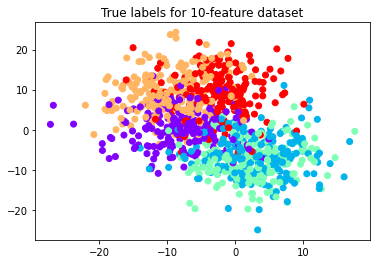

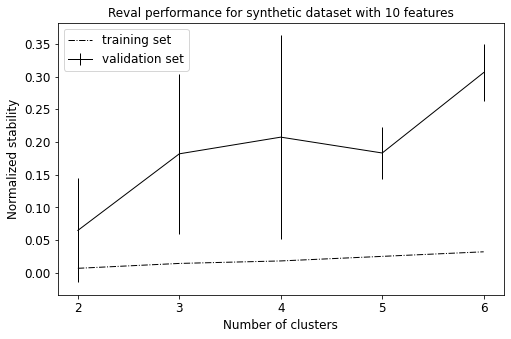

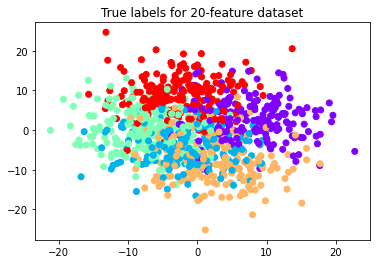

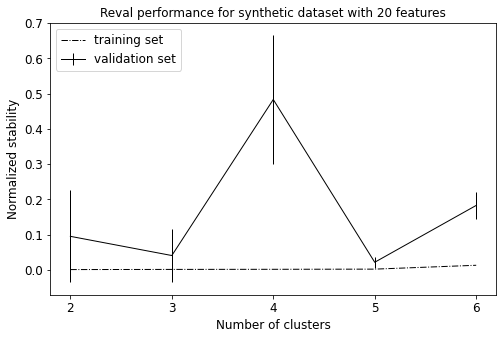

AMI test set = 0.9785165930318929
ACC test set = 0.9933333333333333


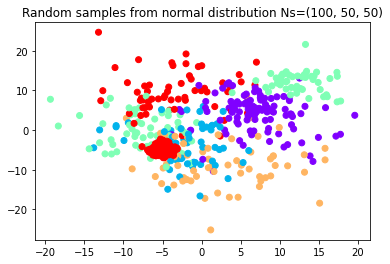

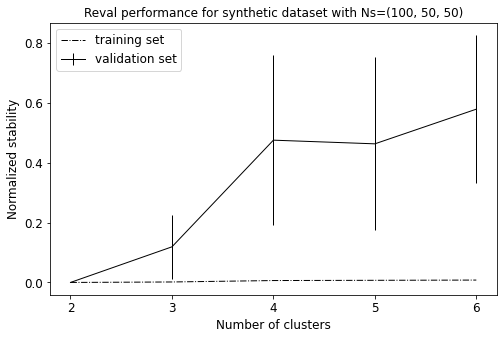

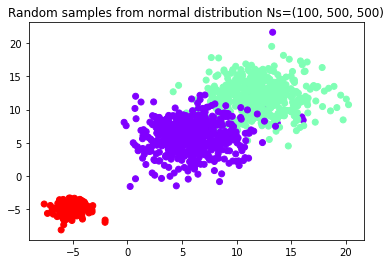

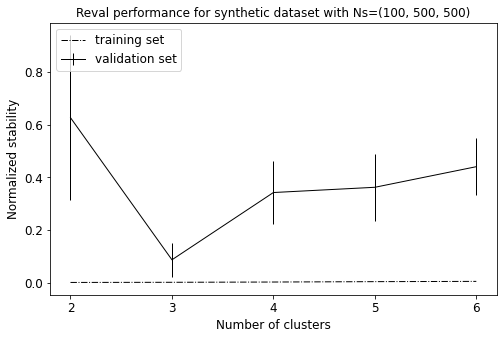

Test set external ACC = 0.9454545454545454
Validation stability metrics: (0.0869826341006306, (0.0869826341006306, 0.06542703852604627))
Test set model ACC = 0.9878787878787879
AMI = 0.7909623557331983


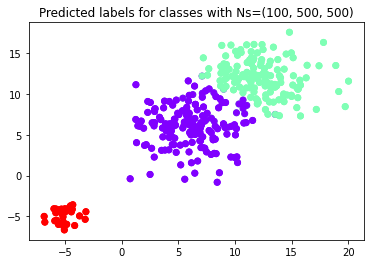

In [69]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from reval.best_nclust_cv import FindBestClustCV
from reval.visualization import plot_metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_mutual_info_score, zero_one_loss
from reval.utils import kuhn_munkres_algorithm
import matplotlib.pyplot as plt
import numpy as np

data1 = make_blobs(1000, 10, centers=5, cluster_std=5, random_state=42)

plt.scatter(data1[0][:, 0], data1[0][:, 1],
            c=data1[1], cmap='rainbow_r')
plt.title('True labels for 10-feature dataset')

X_tr, X_ts, y_tr, y_ts = train_test_split(data1[0],
                                          data1[1],
                                          test_size=0.30,
                                          random_state=42,
                                          stratify=data1[1])
# Apply relative clustering validation with KNN and Hierarchical clustering
classifier = KNeighborsClassifier()
clustering = AgglomerativeClustering()

findbestclust = FindBestClustCV(nfold=10,
                                nclust_range=list(range(2, 7)),
                                s=classifier,
                                c=clustering,
                                nrand=100)
metrics, nbest = findbestclust.best_nclust(data=X_tr, strat_vect=y_tr)
out = findbestclust.evaluate(X_tr, X_ts, nbest)

plot_metrics(metrics, title="Reval performance for synthetic dataset with 10 features")


data2 = make_blobs(1000, 20, centers=5, cluster_std=5, random_state=42)

plt.scatter(data2[0][:, 0], data2[0][:, 1],
            c=data2[1], cmap='rainbow_r')
plt.title('True labels for 20-feature dataset')

X_tr, X_ts, y_tr, y_ts = train_test_split(data2[0],
                                          data2[1],
                                          test_size=0.30, random_state=42,
                                          stratify=data2[1])

findbestclust = FindBestClustCV(nfold=10, nclust_range=list(range(2, 7)),
                                s=classifier, c=clustering, nrand=100)
metrics, nbest = findbestclust.best_nclust(data=X_tr, strat_vect=y_tr)
out = findbestclust.evaluate(X_tr, X_ts, nbest)

plot_metrics(metrics, title="Reval performance for synthetic dataset with 20 features")

plt.scatter(X_ts[:, 0], X_ts[:, 1],
            c=out.test_cllab, cmap='rainbow_r')
plt.title("Predicted labels for 20-feature dataset")

print(f'AMI test set = {adjusted_mutual_info_score(y_ts, out.test_cllab)}')
relabeling = kuhn_munkres_algorithm(y_ts, out.test_cllab)
print(f'ACC test set = {1 - zero_one_loss(y_ts, relabeling)}')

# Set seed for reproducible examples
np.random.seed(42)

# We generate three random samples from normal distributions
data1 = np.random.normal(-5, size=(100, 2))
data2 = np.random.normal(12, 2.5, size=(50, 2))
data3 = np.random.normal(6, 2.5, size=(50, 2))
data = np.append(data1, data2, axis=0)
data = np.append(data, data3, axis=0)

label = [0] * 100 + [1] * 50 + [2] * 50

plt.scatter(data[:, 0], data[:, 1],
            c=label, cmap='rainbow_r')
plt.title('Random samples from normal distribution Ns=(100, 50, 50)')

classifier = KNeighborsClassifier()
clustering = AgglomerativeClustering()

X_tr, X_ts, y_tr, y_ts = train_test_split(data, label,
                                          test_size=0.30,
                                          random_state=42,
                                          stratify=label)

# Apply relative clustering validation with KNN and Hierarchical clustering
findbestclust = FindBestClustCV(nfold=10, nclust_range=list(range(2, 7)),
                                s=classifier, c=clustering, nrand=100)
metrics, nbest = findbestclust.best_nclust(data=X_tr, strat_vect=y_tr)
out = findbestclust.evaluate(X_tr, X_ts, nbest)
plot_metrics(metrics, title="Reval performance for synthetic dataset with Ns=(100, 50, 50)")

plt.scatter(X_ts[:, 0], X_ts[:, 1],
            c=kuhn_munkres_algorithm(np.array(y_ts),
                                      out.test_cllab),
            cmap='rainbow_r')
plt.title(f'Predicted labels for classes with Ns=(100, 50, 50)')

# We now increase the number of samples in groups 2 and 3 to 500
data1 = np.random.normal(-5, size=(100, 2))
data2 = np.random.normal(12, 2.5, size=(500, 2))
data3 = np.random.normal(6, 2.5, size=(500, 2))
data = np.append(data1, data2, axis=0)
data = np.append(data, data3, axis=0)

label = [0] * 100 + [1] * 500 + [2] * 500

plt.scatter(data[:, 0], data[:, 1],
            c=label, cmap='rainbow_r')
plt.title('Random samples from normal distribution Ns=(100, 500, 500)')

classifier = KNeighborsClassifier()
clustering = AgglomerativeClustering()

X_tr, X_ts, y_tr, y_ts = train_test_split(data, label,
                                          test_size=0.30,
                                          random_state=42,
                                          stratify=label)

# Apply relative clustering validation with KNN and Hierarchical clustering
findbestclust = FindBestClustCV(nfold=10, nclust_range=list(range(2, 7)),
                                s=classifier, c=clustering, nrand=100)
metrics, nbest = findbestclust.best_nclust(X_tr, strat_vect=y_tr)
out = findbestclust.evaluate(X_tr, X_ts, nbest)
plot_metrics(metrics, title="Reval performance for synthetic dataset with Ns=(100, 500, 500)")

plt.scatter(X_ts[:, 0], X_ts[:, 1],
            c=y_ts,
            cmap='rainbow_r')
plt.title(f'Test set true labels for classes with Ns=(100, 500, 500)')

plt.scatter(X_ts[:, 0], X_ts[:, 1],
            c=kuhn_munkres_algorithm(np.array(y_ts),
                                      out.test_cllab),
            cmap='rainbow_r')
plt.title(f'Predicted labels for classes with Ns=(100, 500, 500)')

# Performance scores
# Test set ACC
print(f'Test set external '
      f'ACC = {1 - zero_one_loss(y_ts, kuhn_munkres_algorithm(np.array(y_ts), out.test_cllab))}')
print(f"Validation stability metrics: {metrics['val'][nbest]}")
print(f"Test set model ACC = {out.test_acc}")
print(f"AMI = {adjusted_mutual_info_score(y_ts, out.test_cllab)}")